### Analyzing Player Motion: Making a Movie, Measuring Player Speed, and Creating Summaries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ffmpeg

import scipy.signal as signal

In [48]:
DATADIR2 = r"C:\Users\MustaphaM\Desktop\sample-data-master\data\Sample_Game_2\Sample_Game_2_RawEventsData.csv"

### Read in the events data

In [49]:
events = pd.read_csv(DATADIR2)

In [50]:
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [51]:
events.columns

Index(['Team', 'Type', 'Subtype', 'Period', 'Start Frame', 'Start Time [s]',
       'End Frame', 'End Time [s]', 'From', 'To', 'Start X', 'Start Y',
       'End X', 'End Y'],
      dtype='object')

In [52]:
# a function that converts positions from Metrica units to meters (with origin at centre circle)

def to_metric_coordinates(data, field_dimen = (106., 68.), inplace = False):
    ''' 
    convert positions from Metrica units to meters (with origin at centre circle)
    '''
    new_data = data.copy()
    if inplace == True:
        x_columns = [c for c in data.columns if c[-1].lower()=="x"]
        y_columns = [c for c in data.columns if c[-1].lower()=="y"]
        data[x_columns]= (data[x_columns]-0.5)*field_dimen[0]
        data[y_columns]= -1*(data[y_columns]-0.5)*field_dimen[1]
        return data
    else:
        x_columns = [c for c in new_data.columns if c[-1].lower()=="x"]
        y_columns = [c for c in new_data.columns if c[-1].lower()=="y"]
        new_data[x_columns]= (new_data[x_columns]-0.5)*field_dimen[0]
        new_data[y_columns]= -1*(new_data[y_columns]-0.5)*field_dimen[1]
        return new_data
        

#conversion

to_metric_coordinates(events)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,4.24,-18.36,-22.26,17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,-20.14,13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,-19.08,13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,-16.96,12.24,NaN,NaN


In [53]:
events_metr = events.copy()
events = to_metric_coordinates(events_metr)

In [54]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,4.24,-18.36,-22.26,17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,-20.14,13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,-19.08,13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,-16.96,12.24,NaN,NaN


### Read in the tracking data

In [55]:
import csv
def tracking_data(DATADIR,game_id,teamname):
    '''
    tracking_data(DATADIR,game_id,teamname):
    read Metrica tracking data for game_id and return as a DataFrame. 
    teamname is the name of the team in the filename. For the sample data this is either 'Home' or 'Away'.
    '''
    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking

In [56]:
DataDir= r"C:\Users\MustaphaM\Desktop\sample-data-master\data"
tracking_Hom = tracking_data(DataDir, 2, "Home")
tracking_Awa = tracking_data(DataDir,2,"Away")

Reading team: home
Reading team: away


### Convert positions from metrica units to meters

In [57]:

tracking_HomeConv = tracking_Hom.copy()
tracking_AwayConv = tracking_Awa.copy()

tracking_Home = to_metric_coordinates(tracking_HomeConv)
tracking_Away = to_metric_coordinates(tracking_AwayConv)

tracking_Home 

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,5646.08,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09392,-30.29672,-23.36028,9.04400,NaN,NaN
141153,2,5646.12,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09286,-30.34568,-23.31046,9.03176,NaN,NaN
141154,2,5646.16,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09074,-30.40348,-23.28714,9.02632,NaN,NaN


### Reverse direction of player so that home team is always attacking right --> left

In [58]:
def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away,events]:
        second_half_idx = team.Period.idxmax(2)
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home,away,events

In [59]:
tracking_Home, tracking_Away, events = to_single_playing_direction(tracking_Home, tracking_Away, events)

### Making a movie

In [60]:
def save_match_clip(hometeam,awayteam, fpath, fname='clip_test', figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7):
    """ save_match_clip( hometeam, awayteam, fpath )
    
    Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
    Parameters
    -----------
        hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
        awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
        fpath: directory to save the movie
        fname: movie filename. Default is 'clip_test.mp4'
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        frames_per_second: frames per second to assume when generating the movie. Default is 25.
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    # create football pitch
    if figax is None:
        fig,ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig,ax = figax
    fig.set_tight_layout(True)
    # Generate movie
    print("Generating movie...",end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
            # plot ball
            objs, = ax.plot( team['ball_x'], team['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)
            # include match time at the top
            frame_minute =  int( team['Time [s]']/60. )
            frame_second =  ( team['Time [s]']/60. - frame_minute ) * 60.
            timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            objs = ax.text(-2.5,field_dimen[1]/2.+1., timestring, fontsize=14 )
            figobjs.append(objs)
            writer.grab_frame()
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
    print("done")
    plt.clf()
    plt.close(fig) 

In [61]:
def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax



In [62]:
PLOTDIR = r"C:\Users\MustaphaM\Desktop\sample-data-master\data\Sample_Game_2"
save_match_clip(tracking_Home.iloc[73600: 73600+500], tracking_Away.iloc[73600:73600+500], PLOTDIR, fname= "home_goal_2", include_player_velocities = False)

Generating movie...done


### Calculate player velocities

In [63]:
def calc_player_velocities(team, smoothing=True, filter_='moving average', window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )
    
    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realistically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added
    """
    # remove any velocity data already in the dataframe
    team = remove_player_velocities(team)
    
    # Get the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()
    
    # index of first frame in second half
    second_half_idx = team.Period.idxmax(2)
    
    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velocity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan
            
        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window 
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' ) 
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )      
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' ) 
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' ) 
                
        
        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team

def remove_player_velocities(team):
    """
    remove player velocities and accelration values that are already in the "team" dataframe 
    """
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']] # Get the player ids
    team = team.drop(columns = columns)
    return team

In [64]:
#calculating the player velocities
tracking_home = calc_player_velocities(tracking_Home, smoothing = True)
tracking_away = calc_player_velocities(tracking_Away, smoothing = True)

In [65]:
tracking_away

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_23_speed,Away_24_vx,Away_24_vy,Away_24_speed,Away_25_vx,Away_25_vy,Away_25_speed,Away_26_vx,Away_26_vy,Away_26_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,-51.70892,-1.19884,-18.19384,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,-51.70892,-1.19884,-18.25002,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,...,0.0,0.0,0.0,0.0,-1.169786,1.245857,1.708964,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,5646.08,-43.68366,-1.14852,1.03032,-37.40000,1.15434,-3.54416,-10.37528,5.07824,...,0.0,0.0,0.0,0.0,1.022143,0.483286,1.130637,-0.552714,-0.364286,0.661965
141153,2,5646.12,-43.66246,-1.14852,1.03032,-37.40000,1.17236,-3.56252,-10.35302,5.10612,...,0.0,0.0,0.0,0.0,0.961571,0.400714,1.041725,-0.503500,-0.279286,0.575771
141154,2,5646.16,-43.63808,-1.14852,1.03032,-37.40000,1.17872,-3.61488,-10.34878,5.13400,...,0.0,0.0,0.0,0.0,0.753357,0.291429,0.807761,-0.416429,-0.235571,0.478442


In [66]:
tracking_Home

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,5646.08,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09392,30.29672,23.36028,-9.04400,NaN,NaN
141153,2,5646.12,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09286,30.34568,23.31046,-9.03176,NaN,NaN
141154,2,5646.16,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09074,30.40348,23.28714,-9.02632,NaN,NaN


### Plot a random frame and show player velocities

In [67]:
def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlhttp://localhost:8888/notebooks/Untitled31.ipynb?kernel_name=python3#Plot-a-random-framepha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xd680bffc08>)

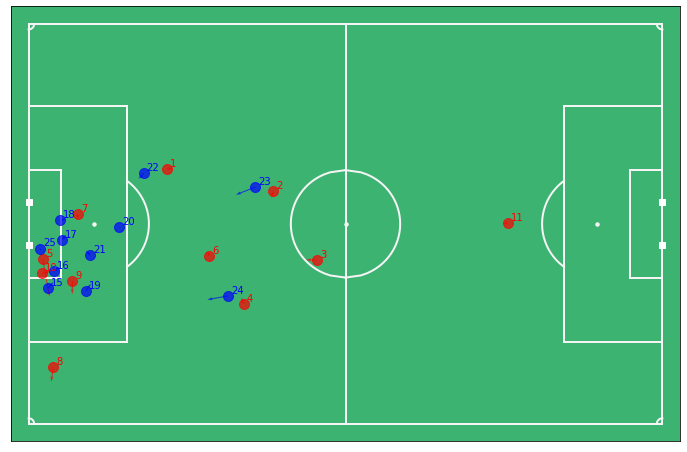

In [68]:
#frame is 10000
plot_frame(tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities = True, annotate = True)

Player velocities are indicated by the arrow lengths, the jersey numbers are also shown.

### Creating the physical summary for the home players

In [69]:
home_players = np.unique([c.split("_")[1] for c in tracking_home.columns if c[:4] == "Home"])
#extracts the jersey numbers
home_summary = pd.DataFrame(index = home_players)
#creates a new dataframe to hold the summary later, each row is the player jersey number

In [70]:
home_summary

""
1
10
11
12
13
14
2
3
4
5


In [71]:
#calculate the minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a 
      #position observation for each player (when a player is not on the pitch, positions are NaN)
    column = "Home_"+player + "_x" #use player x-position coordinate
    player_minutes = (tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1)/25/60
    #there are 25 frames per second, hence the division. Division by 60 is to convert to minutes
    minutes.append(player_minutes)
home_summary["Minutes Played"] = minutes
home_summary = home_summary.sort_values(["Minutes Played"], ascending = False)
    

In [72]:
home_summary

,Minutes Played
1,94.104000
11,94.104000
2,94.104000
3,94.104000
5,94.104000
6,94.104000
7,94.104000
9,94.104000
10,83.825333
8,70.740667


In [73]:
#distance covered
distance = []
for player in home_summary.index:
    column = "Home_"+player+"_speed"
    player_distance = tracking_home[column].sum()/25./1000 #speed times time. covert to km
    distance.append(player_distance)
home_summary["Distance [km]"] = distance

In [74]:
home_summary

,Minutes Played,Distance [km]
1,94.104000,10.369966
11,94.104000,5.203820
2,94.104000,9.845300
3,94.104000,9.546312
5,94.104000,11.909182
6,94.104000,11.535956
7,94.104000,11.068739
9,94.104000,9.765225
10,83.825333,8.959440
8,70.740667,9.012902


As expected, the goalkeeper (i.e player 11) covers one of the smallest distances for the entire duration of the game

Text(0, 0.5, 'Distance covered [km]')

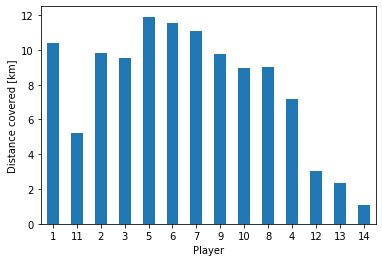

In [75]:
#a bar chart showing the distance covered by each player
plt.subplots()
ax = home_summary["Distance [km]"].plot.bar(rot = 0)
ax.set_xlabel("Player")
ax.set_ylabel("Distance covered [km]")

In [76]:
# distance covered: walking, joggng, running, and sprinting
walking = []
jogging = []
running = []
sprinting = []


for player in home_summary.index:
    column = "Home_"+player+"_speed"
    
    #walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column]<2, column].sum()/25./1000
    walking.append(player_distance)
    
    #jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[(tracking_home[column]>= 2) & (tracking_home[column]<4), column].sum()/25./1000
    jogging.append(player_distance)
    
    #running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[(tracking_home[column]>=4) & (tracking_home[column]<7), column].sum()/25./1000
    running.append(player_distance)
    
    #sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append(player_distance)

home_summary["Walking [km]"] = walking
home_summary["Jogging [km]"] = jogging
home_summary["Running [km]"] = running
home_summary["Sprinting [km]"] = sprinting
    
    

In [77]:
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km]
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669
6,94.104000,11.535956,3.385540,5.145440,2.829522,0.175454
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470
9,94.104000,9.765225,4.428081,3.322470,1.863521,0.151153
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051


Text(0, 0.5, 'Distance covered [km]')

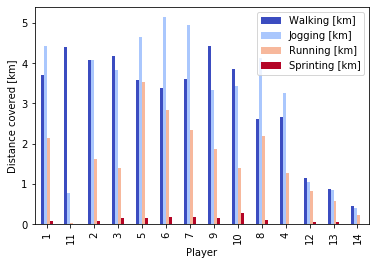

In [78]:
#Making a clustered bar chart
ax = home_summary[["Walking [km]", "Jogging [km]", "Running [km]", "Sprinting [km]"]].plot.bar(colormap="coolwarm")
ax.set_xlabel("Player")
ax.set_ylabel("Distance covered [km]")

In [79]:
#sustained sprints: how many sustained sprints per match?
# sustained sprint occcurs when a player maintains a speed greater than 7m/s for more than a second
nsprints = []
sprint_threshold = 7 #minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 #minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = "Home_"+player+"_speed" 
    # trick here is to convolve speed with a window of size "sprint_window", and find the number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [80]:
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669,8
6,94.104000,11.535956,3.385540,5.145440,2.829522,0.175454,7
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470,9
9,94.104000,9.765225,4.428081,3.322470,1.863521,0.151153,7
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760,13
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051,6


Player 10 made the most number of sprints

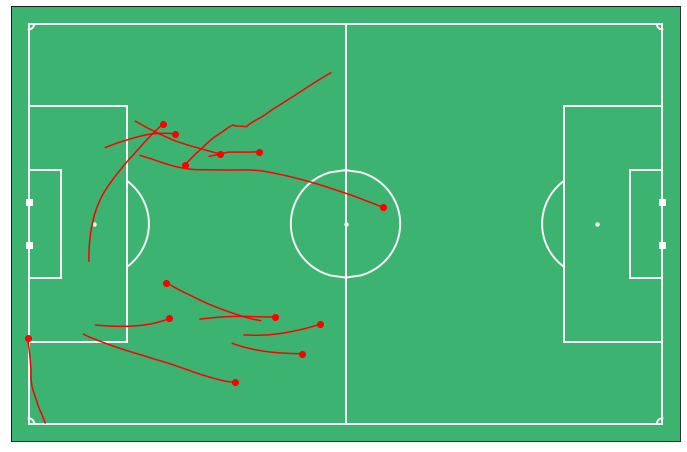

In [82]:
#Plot the sprint trajectories for player 10

# Plot the trajectories for each of player 10's sprints
player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
# now plot all the sprints
fig,ax = plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')